# LLM Text Detection with LSTM
## Overview
In this notebook, we will explore detection whether text is generated by Large Language using LSTM (Long Short-Term Memory) models. By leveraging the power of LSTM, a type of recurrent neural network (RNN), we aim to create a robust model capable of handling complex language patterns and making accurate predictions.

I use this dataset for training:
- https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Loading the Data

 Reading the training dataset from a CSV file

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Dataset/train_v4_drcat_01.csv")
train.head()

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human


In [ ]:
X = train['text']
y = train['label']

In [ ]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 30000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 136301 unique tokens.


In [ ]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (73573, 300)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(55179, 300) (55179,)
(18394, 300) (18394,)


## Training the LSTM Model

In this code, we create a Sequential model using `tf.keras.Sequential`. The model consists of several layers:

- Input layer for text data
- Embedding layer that converts the processed text into dense vectors
- Two Bidirectional LSTM layers that capture the sequential information in both directions
- Dense layers with ReLU activation
- Output layer with sigmoid activation for binary classification

We then compile the model with a binary crossentropy loss, Adam optimizer with a learning rate of 1e-3, and metrics such as accuracy and AUC.

Finally, we print a summary of the model's architecture and plot the model's architecture using `tf.keras.utils.plot_model()`.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           1920000   
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2028321 (7.74 MB)
Trainable params: 202832

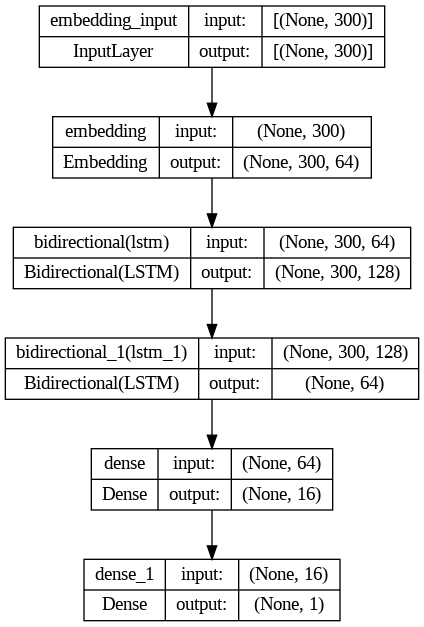

In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(
        input_dim=30000,
        output_dim=64,
        input_length=300,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.fit(X_train,y_train,epochs=1)

1725/1725 [==============================] - 1618s 927ms/step - loss: 0.2011 - accuracy: 0.9239 - auc: 0.9725


In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Evaluation

In [ ]:
val_loss, val_accuracy, val_auc = model.evaluate(X_test,y_test)
print(f"Validation Loss: {val_loss: .4f}")
print(f"Validation Accuracy: {val_accuracy: .4f}")
print(f"Validation AUC: {val_auc: .4f}")

575/575 [==============================] - 121s 200ms/step - loss: 0.1815 - accuracy: 0.9444 - auc: 0.9742
Validation Loss:  0.1815
Validation Accuracy:  0.9444
Validation AUC:  0.9742


In [ ]:
input_txt = tokenizer.texts_to_sequences(['We then compile the model with a binary crossentropy loss, Adam optimizer with a learning rate of 1e-3, and metrics such as accuracy and AUC.'])
input_txt = pad_sequences(input_txt, maxlen=300)

predict_x=model.predict(input_txt)
classes_x=np.argmax(predict_x,axis=1)
classes_x

1/1 [==============================] - 7s 7s/step


array([0])

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
tf.__version__

'2.15.0'

## Conclusion

In this notebook, we have shown how to use a LSTM neural network to detect whether given text is generated by Large Language Models. We started by loading the data and exploring its features. Then, we trained the LSTM model and evaluated its performance. Finally we create a submission for this competition. This model could achieve 99.8% validation AUC on the given dataset and 83.1% AUC on the public leader board.